# Praca domowa z ML numer 5

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Kernel_methods/homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

#### Posłużymy się zbiorem danych takim jak na zajęciach, to znaczy narysujemy "kołowe" zbiory danych i zastosujemy algorytm SVM.

###### Poniższy kawałek kodu pochodzi z zajęć

### UWAGA!!! Poniższy plik był za duży, aby go wgrać na githuba i aby był dostępny preview, więc musiałem usunąć animacje. Wobec tego należy odpalić plik od początku!!!

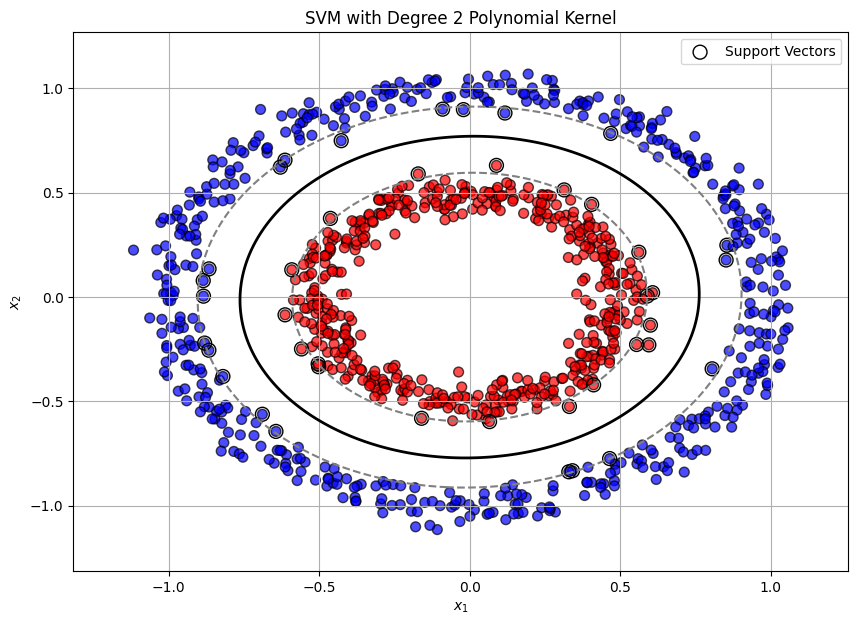

In [30]:
# Generujemy dane
np.random.seed(42)
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.05)

#normalizacja, czyli zastąpienie labelek przez 1 i -1
y = np.where(y == 0, -1, 1)

#trenujemy algorytm svm, stosując tak jak na zajęciach wielomianowe jądro
clf = SVC(kernel='poly', degree=2, C=1.0, coef0=0, gamma=1)
clf.fit(X, y)


#tutaj plotujemy nasze dane
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=50, alpha=0.7)

plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
plt.contour(xx, yy, Z, levels=[-1, 1], linestyles='--', colors='grey')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='k', label='Support Vectors')

plt.title('SVM with Degree 2 Polynomial Kernel')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)



Na zajęciach zauważyliśmy już, że granica decyzyjna jest elipsoidą w tym wypadku. Należy wspomnieć, że tak jak na zajęciach wykorzystaliśmy następujące jądro
$$
K(x, x') = (x^T x' + c)^d,
$$
gdzie d = 2 oraz c = 0 dla uproszczenia. Wyznaczenie przekształcenia związanego z tym jądrem jest proste. W szczególności otrzymujemy
$$
K(x, x') = (x_1 x_1' + x_2 x_2')^2 = x_1^2 x_1'^2 + 2x_1 x_1' x_2 x_2' + x_2^2 x_2'^2,
$$
a stąd
$$
\phi(x) = [x_1^2, \sqrt{2} x_1 x_2, x_2^2].
$$


###### Poniższy kawałek kodu pochodzi z zajęć, ale został rozszezrony o animację, aby lepiej przyjrzeć się transformowanym danym. Ta komórka może się chwilkę renderować ~ 30 s.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Transformacja danych do 3D
phi_X = np.array([[x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2] for x in X])
phi_grid = np.array([[x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2] for x in grid])

#Plotujemy dane
sc = ax.scatter(phi_X[:, 0], phi_X[:, 1], phi_X[:, 2], c=y, cmap='bwr', edgecolors='k', s=50, alpha=0.7, label='Dane')

# Granica decyzyjna
Z = clf.decision_function(grid)
contour_mask = np.isclose(Z, 0, atol=0.01) 
db = ax.scatter(phi_grid[contour_mask, 0], phi_grid[contour_mask, 1], phi_grid[contour_mask, 2],
                c='k', s=5, label='Granica decyzyjna')

ax.set_title(r'Przekształcenie $\phi(x) = [x_1^2, \sqrt{2} x_1 x_2, x_2^2]$ z granicą decyzyjną')
ax.set_xlabel(r'$x_1^2$')
ax.set_ylabel(r'$\sqrt{2} x_1 x_2$')
ax.set_zlabel(r'$x_2^2$')
ax.legend()
ax.grid(True)

# Funkcja do animacji obrotu
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# Animacja
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 180, 2), interval=50)

HTML(ani.to_jshtml())

Spodziewaliśmy się granicy decyzyjnej w postaci hiperpłaszczyzny, a jednak otzrymaliśmy elipsoidę. Jest to związane z geometrią przekształcenia $\phi$ i ztego jak wygląda proces wizualizacji danych. Przede wszytskim, aby zwizualizować dane, na początku oszacowaliśmy SVM dla jądra wielomianowego, następnie przenieśliśmy dane do trzech wymiarów, więc w szczególności przenieśliśmy również granicę decyzyjną poddając ją przekształceniu $\phi$. Przyjrzyjmy się na początku co zrobi nasz algorytm SVM w takim przypadku. 

Przede wszytskim chcemy zminimalizować $\textit{margin}$ przy danych wejściowych poddajać je działaniu przekształcenia $\phi$. W szczególności granica decyzyjna będzie postaci
$$
w^T \phi(x) + b = 0.
$$
Proste przekształcenia oraz rozpisanie w postaci probelmu dualnego dadzą następujący
$$
\sum_{i=1}^{n} \alpha_i y_i K(x_i', x) + b = 0,
$$
gdzie
$$
K(x, x') = (x_1 x_1' + x_2 x_2')^2 = x_1^2 x_1'^2 + 2x_1 x_1' x_2 x_2' + x_2^2 x_2'^2.
$$
Po przekształceniach można zauważyć, że otrzymujemy równanie elipsoidy z odpowiednimi współczynnikami związanymi z danymi treningowymi.
$$
\sum_{i=1}^{n} \alpha_i y_i K(x_i', x) + b = 0 \iff x_1^2 \Big(\sum_{i=1}^{n} \alpha_i y_i x_{1,i}'^2\Big) + 2x_1x_2\Big(\sum_{i=1}^{n} \alpha_i y_i x_{1,i}x_{2,i}\Big) + x_2^2 \Big(\sum_{i=1}^{n} \alpha_i y_i x_{2,i}'^2\Big) + b = 0.
$$
W ten sposób podczas wizualizacji w 2D otzrymujemy granicę decyzyjną w postaci elipsoidy. Późniejsze przeniesienie danych do trzech wymiarów również daje granicę decyzyjną w postaci elipsoidy (ale w $\mathbb{R}^3$), ponieważ $\phi$ przekształca elipsy na elipsoidy, co można zobaczyć na poniższych wykresach.

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Jakub\AppData\Local\Temp\ipykernel_4924\3325635635.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_title(f'Obraz w $\mathbb{{R}}^3$')


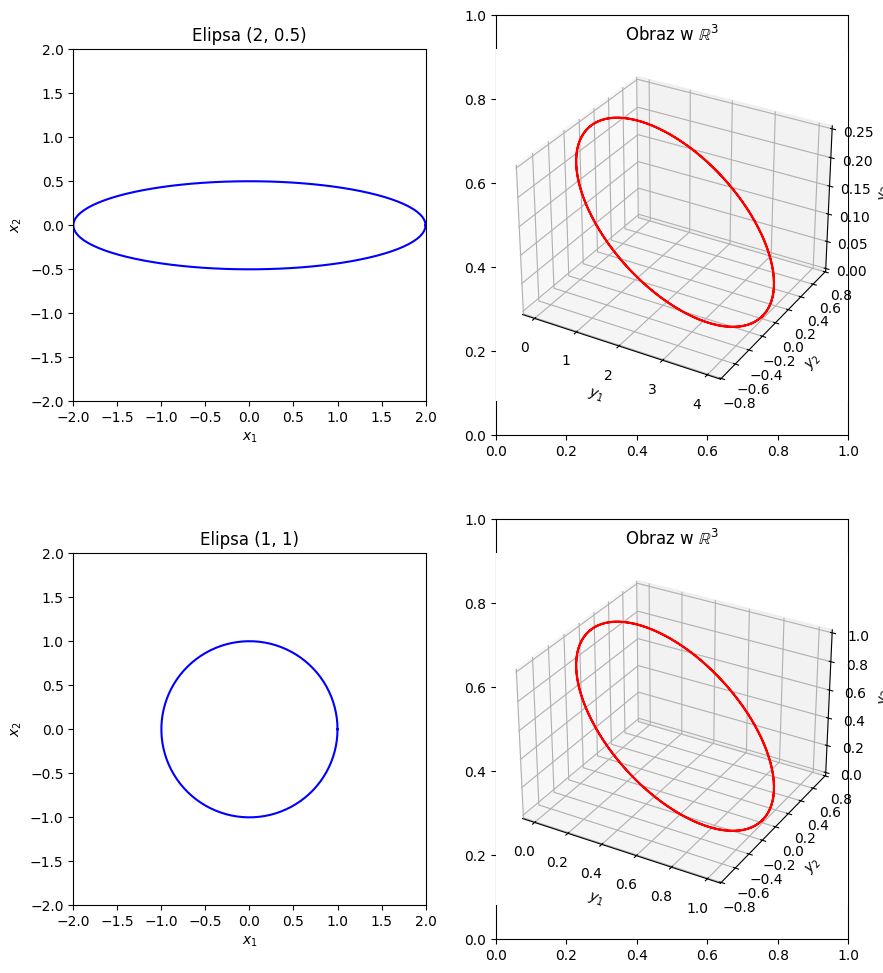

In [32]:

def phi(x1, x2):
    return np.array([x1**2, np.sqrt(2) * x1 * x2, x2**2])

# Parametry elips
ellipses = [(2, 0.5), (1,1)]

fig, axes = plt.subplots(2, 2, figsize=(10, 12), subplot_kw={'projection': None})

for i, (a, b) in enumerate(ellipses):
    theta = np.linspace(0, 2 * np.pi, 100)
    x1 = a * np.cos(theta)
    x2 = b * np.sin(theta)
    
    # Obraz pod phi
    transformed = np.array([phi(x1[j], x2[j]) for j in range(len(theta))])
    
    # Wykres elipsy
    ax1 = axes[i, 0]
    ax1.plot(x1, x2, 'b')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_title(f'Elipsa ({a}, {b})')
    ax1.set_aspect('equal')
    
    # Wykres 3D obrazu
    ax2 = fig.add_subplot(2, 2, 2*i+2, projection='3d')
    ax2.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2], 'r')
    ax2.set_xlabel('$y_1$')
    ax2.set_ylabel('$y_2$')
    ax2.set_zlabel('$y_3$')
    ax2.set_title(f'Obraz w $\mathbb{{R}}^3$')
    


In [33]:
# Zakładam, że masz już dane phi_X i y
# phi_X to transformowane dane
data_x = phi_X
data_labels = y

# Trenowanie klasyfikatora SVM
clf1 = SVC(kernel='linear', C=1e5)
clf1.fit(data_x, data_labels)

# Pobranie współczynników hiperplanu
w = clf1.coef_[0]
b = clf1.intercept_[0]


###### Poniższe renderuje się ~30s.

In [ ]:
# Tworzenie siatki punktów
x2_min, x2_max = data_x[:, 1].min() - 0.5, data_x[:, 1].max() + 0.5
x3_min, x3_max = data_x[:, 2].min() - 0.5, data_x[:, 2].max() + 0.5
x2, x3 = np.meshgrid(np.linspace(x2_min, x2_max, 60), np.linspace(x3_min, x3_max, 60))

def hyperplane(x2, x3, offset=0):
    return -(w[1] * x2 + w[2] * x3 + b - offset) / w[0]

# marginesy i hiperpłaszczyzna
y_decision = hyperplane(x2, x3, offset=0)
y_margin_plus = hyperplane(x2, x3, offset=1)
y_margin_minus = hyperplane(x2, x3, offset=-1)

#wykresy
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phi_X[:, 0], phi_X[:, 1], phi_X[:, 2], c=y, cmap='coolwarm', edgecolors='k', s=40, alpha=0.8, label="Dane")

# Rysowanie hipepłaszczyzny i marginesów
ax.plot_surface(y_decision, x2, x3, color='gray', alpha=0.6, rstride=5, cstride=5, edgecolor='none', label="Granica decyzyjna")
ax.plot_surface(y_margin_plus, x2, x3, color='tomato', alpha=0.2, rstride=5, cstride=5, edgecolor='none', label="Margin +1")
ax.plot_surface(y_margin_minus, x2, x3, color='dodgerblue', alpha=0.2, rstride=5, cstride=5, edgecolor='none', label="Margin -1")

ax.set_xlim([phi_X[:, 0].min() - 0.5, phi_X[:, 0].max() + 0.5])
ax.set_ylim([x2_min, x2_max])
ax.set_zlim([x3_min, x3_max])

ax.set_xlabel("$z_1 (x_1^2)$", fontsize=12, labelpad=10)
ax.set_ylabel("$z_2 ( \sqrt{2} x_1 x_2)$", fontsize=12, labelpad=10)
ax.set_zlabel("$z_3 (x_2)^2$", fontsize=12, labelpad=10)
ax.set_title("Rozdzielone dane z granicą dezyzyjną ", fontsize=14, pad=15)

# Funkcja do animacji obrotu
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# Tworzenie animacji
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 180, 2), interval=40)

HTML(ani.to_jshtml())


Zauważmy jeszcze, że w przypadku przeniesienia danych do trzech wymiarów i dopiero potem oszacowanie SVM zwraca spodziewaną hiperpłaszczyznę. Można się w takim razie zastanaowić czemu w takim razie otrzymujemy elipsę w dwóch wymiarach (po poworcie od przekształcenia $\phi$). Tutaj ponownie trzeba przyjrzeć się problemowi od końca. W przypadku oszacowania SVM na danych trójwymiarowych otrzymujemy hipepłaszczyzę co wynika ze specyfiki problemu, to znaczy otrzymujemy już na początku separowalne dane (separowalne hiperpłąszczyzną) i dostajemy "zwykły" problem SVM. Natomiast jak wspomniano wcześniej w przypadku dwuwymiarowym transformacja danych prowadzi do rozwiązanie nietrywialnego równania kwadratowego (przy ograniczeniach), które wyznacza elispę.